In [33]:
import ruclip
import torch
from huggingface_hub import hf_hub_url, cached_download
from ruclip import model, processor, predictor
from ruclip.model import CLIP
from ruclip.processor import RuCLIPProcessor
from ruclip.predictor import Predictor
import pandas as pd
from PIL import Image
import io
import base64
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [47]:
class ruClipTopK:
    def __init__(self, device, topK, templates):
        self.topK = topK
        self.device = device
        self.clip = CLIP.from_pretrained("/home/jupyter/datasphere/project/asd/ruclip-vit-base-patch16-384").eval().to(device)
        self.clip_processor = RuCLIPProcessor.from_pretrained("/home/jupyter/datasphere/project/asd/ruclip-vit-base-patch16-384")
        self.predictor = ruclip.Predictor(self.clip, self.clip_processor, device, bs=8, templates=templates)
    
    def get_single_text_embedding(self,text): 
        with torch.no_grad():
            text_embeddings = self.predictor.get_text_latents([text])
     
        embedding_as_np = text_embeddings.cpu().detach().numpy()

        return embedding_as_np
    
    def get_single_image_embedding(self,image):
        with torch.no_grad():
            embedding = self.predictor.get_image_latents([image])
            embedding_as_np = embedding.cpu().detach().numpy()
        return embedding_as_np
    def get_top_N_images(self,query, data, top_K=100): 
        query_vect = self.get_single_text_embedding(query)
        revevant_cols = ["image", "cos_sim"]
        data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))
        data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])
        filters = []
        n = self.topK
        most_similar = pd.DataFrame(data.sort_values(by='cos_sim', ascending=False))
        places = pd.DataFrame(columns= ["name", "image", "img_embeddings", "cos_sim"])
        for index, row in most_similar.iterrows():
            if row["name"].lower() not in filters:
                places.loc[index] = row;
                filters.append(row["name"].lower())
            if len(places) == n:
                break;       
        return places[revevant_cols].reset_index()
    def plot_images_by_side(self,top_images, n_row, n_col):
        index_values = list(top_images.index.values)
        list_images = [top_images.iloc[idx].image for idx in index_values] 
        similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values] 
        _, axs = plt.subplots(n_row, n_col, figsize=(15, 15))
        axs = axs.flatten()
        for img, ax,  sim_score in zip(list_images, axs,  similarity_score):
            ax.imshow(img)
            sim_score = 100*float("{:.2f}".format(sim_score))
            ax.title.set_text(f"Similarity: {sim_score}%")
        plt.show()
    def get_all_images_embedding(self,df):
        df["img_embeddings"] = df[str("image")].apply(self.get_single_image_embedding)
        return df
    def get_total_embds(self,df, df_places, img_column, captions_column):
        temp_lst = []
        for index, row in df.iterrows():
            temp_lst.append(self.get_single_image_embedding(row["image"]))
        df["img_embeddings"] = temp_lst
        temp_lst = []
        for index, row  in df_places.iterrows():
            temp_vec = 0
            for j in row[captions_column].split(" "):
                    temp_vec += self.get_single_text_embedding(j)
            temp_lst.append(temp_vec)
        df_places["captions_embds"] = temp_lst
        temp_lst = []
        for index, row in df.iterrows():
            temp_lst.append(df_places[df_places["Name"] == row["name"]]["captions_embds"])
      
        df["captions_embds"] = temp_lst
        return df
    

In [105]:
def get_single_text_embedding(text): 
    with torch.no_grad():
        text_embeddings = predictor.get_text_latents([text])
    embedding_as_np = text_embeddings.cpu().detach().numpy()
    return embedding_as_np

In [171]:
def get_single_image_embedding(image):
  with torch.no_grad():
        embedding = predictor.get_image_latents([image])
  embedding_as_np = embedding.cpu().detach().numpy()
  return embedding_as_np

In [106]:
def get_top_N_images(query, data, top_K=100, search_criterion="text"):
    if(search_criterion.lower() == "text"):
      query_vect = get_single_text_embedding(query)
    else: 
      query_vect = get_single_image_embedding(query )
    # Relevant columns
    revevant_cols = ["image", "cos_sim"]
    # Run similarity Search
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))
    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])
    filters = []
    n = 10
    most_similar = pd.DataFrame(data.sort_values(by='cos_sim', ascending=False))
    places = pd.DataFrame(columns= ["name", "image", "img_embeddings", "cos_sim"])
    for index, row in most_similar.iterrows():
        if row["name"].lower() not in filters:
            places.loc[index] = row;
            filters.append(row["name"].lower())
        if len(places) == n:
            break;
    print(filters)        
    return places[revevant_cols].reset_index()

In [174]:
def get_all_images_embedding(df):
  df["img_embeddings"] = df[str("image")].apply(get_single_image_embedding)
  return df

In [127]:
def plot_images_by_side(top_images):

  index_values = list(top_images.index.values)
  print(len(index_values))
  list_images = [top_images.iloc[idx].image for idx in index_values] 
  
  similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values] 

  n_row = 5
  n_col = 2
  _, axs = plt.subplots(n_row, n_col, figsize=(15, 15))
  axs = axs.flatten()
  for img, ax,  sim_score in zip(list_images, axs,  similarity_score):
      ax.imshow(img)
      sim_score = 100*float("{:.2f}".format(sim_score))
      ax.title.set_text(f"Similarity: {sim_score}%")
  plt.show()

In [ ]:
def get_total_embds(df, df_places, img_column, captions_column):
    temp_lst = []
    for index, row in df.iterrows():
        temp_lst.append(get_single_image_embedding(row["image"]))
    df["img_embeddings"] = temp_lst
    temp_lst = []
    for index, row  in df_places.iterrows():
        temp_vec = 0
        for j in row[captions_column].split(" "):
                temp_vec += get_single_text_embedding(j)
        temp_lst.append(temp_vec)
    df_places["captions_embds"] = temp_lst
    temp_lst = []
    for index, row in df.iterrows():
        temp_lst.append(df_places[df_places["Name"] == row["name"]]["captions_embds"])
    df["captions_embds"] = temp_lst
    return df

In [51]:
EKB_img = pd.read_csv("/home/jupyter/datasphere/project/asd/data/EKB_img.csv")
NN_img = pd.read_csv("/home/jupyter/datasphere/project/asd/data/NN_img.csv")
VLD_img = pd.read_csv("/home/jupyter/datasphere/project/asd/data/Vladimir_img.csv")
YAR_img = pd.read_csv("/home/jupyter/datasphere/project/asd/data/Yaroslavl_images_pil.csv")
EKB_places = pd.read_csv("/home/jupyter/datasphere/project/asd/data/EKB_places_pure.csv")
NN_places = pd.read_csv("/home/jupyter/datasphere/project/asd/data/NN_places_pure.csv")
VLD_places = pd.read_csv("/home/jupyter/datasphere/project/asd/data/VLAD_places_pure.csv")
YAR_places = pd.read_csv("/home/jupyter/datasphere/project/asd/data/YAROSLAVL_places_pure.csv")

1it [00:00, 66.21it/s]
1it [00:00, 68.06it/s]
1it [00:00, 68.44it/s]
1it [00:00, 66.34it/s]
1it [00:00, 72.98it/s]
1it [00:00, 70.51it/s]
1it [00:00, 70.63it/s]
1it [00:00, 70.29it/s]
1it [00:00, 70.66it/s]
1it [00:00, 70.95it/s]
1it [00:00, 70.00it/s]
1it [00:00, 64.58it/s]
1it [00:00, 72.88it/s]
1it [00:00, 68.65it/s]
1it [00:00, 69.50it/s]
1it [00:00, 72.94it/s]
1it [00:00, 70.30it/s]
1it [00:00, 72.19it/s]
1it [00:00, 72.48it/s]
1it [00:00, 72.76it/s]
1it [00:00, 74.22it/s]
1it [00:00, 75.26it/s]
1it [00:00, 71.15it/s]
1it [00:00, 65.88it/s]
1it [00:00, 68.86it/s]
1it [00:00, 72.73it/s]
1it [00:00, 70.59it/s]
1it [00:00, 71.30it/s]
1it [00:00, 70.29it/s]
1it [00:00, 69.65it/s]
1it [00:00, 69.50it/s]
1it [00:00, 67.87it/s]
1it [00:00, 69.17it/s]
1it [00:00, 65.53it/s]
1it [00:00, 69.37it/s]
1it [00:00, 66.94it/s]
1it [00:00, 66.95it/s]
1it [00:00, 70.24it/s]
1it [00:00, 70.64it/s]
1it [00:00, 69.88it/s]
1it [00:00, 72.21it/s]
1it [00:00, 70.85it/s]
1it [00:00, 71.78it/s]
1it [00:00,

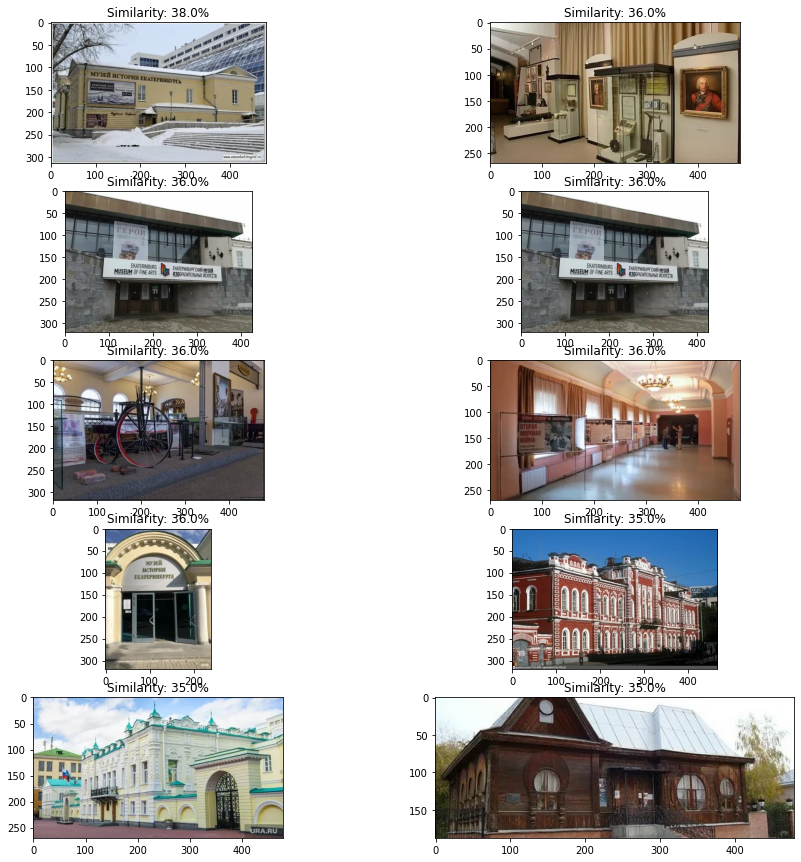

In [52]:
templates = ['{}', 'это {}', 'на картинке {}']
model = ruClipTopK("cuda", 10, templates)
images = [Image.open(io.BytesIO(base64.b64decode(i))) for i in EKB_img["image"]]
EKB_img["image"] = images    
EKB_img = model.get_total_embds(EKB_img, EKB_places, "image", "russian_captions")
top_images = model.get_top_N_images("исторический музей", EKB_img)
model.plot_images_by_side(top_images,5,2)

In [206]:

#get_total_embds(NN_img, NN_places, "image", "russian_captions")
#get_total_embds(VLD_img, VLD_places, "image", "russian_captions")
#get_total_embds(YAR_img, YAR_places, "image", "russian_captions")

1it [00:00, 60.59it/s]
1it [00:00, 68.21it/s]
1it [00:00, 68.72it/s]
1it [00:00, 67.74it/s]
1it [00:00, 68.98it/s]
1it [00:00, 68.77it/s]
1it [00:00, 69.94it/s]
1it [00:00, 68.48it/s]
1it [00:00, 70.36it/s]
1it [00:00, 70.85it/s]
1it [00:00, 72.83it/s]
1it [00:00, 71.86it/s]
1it [00:00, 74.78it/s]
1it [00:00, 76.38it/s]
1it [00:00, 71.77it/s]
1it [00:00, 65.81it/s]
1it [00:00, 72.89it/s]
1it [00:00, 70.57it/s]
1it [00:00, 69.92it/s]
1it [00:00, 67.94it/s]
1it [00:00, 70.59it/s]
1it [00:00, 70.94it/s]
1it [00:00, 67.29it/s]
1it [00:00, 70.63it/s]
1it [00:00, 71.58it/s]
1it [00:00, 69.38it/s]
1it [00:00, 71.73it/s]
1it [00:00, 73.67it/s]
1it [00:00, 72.45it/s]
1it [00:00, 74.59it/s]
1it [00:00, 67.72it/s]
1it [00:00, 69.98it/s]
1it [00:00, 70.79it/s]
1it [00:00, 68.98it/s]
1it [00:00, 68.25it/s]
1it [00:00, 70.66it/s]
1it [00:00, 72.81it/s]
1it [00:00, 71.94it/s]
1it [00:00, 70.32it/s]
1it [00:00, 68.84it/s]
1it [00:00, 70.86it/s]
1it [00:00, 69.29it/s]
1it [00:00, 68.54it/s]
1it [00:00,

ValueError: Data must be 1-dimensional